# Thư viện

In [2]:
%pip install ray
%pip install torch transformers scikit-learn -q flwr[simulation] flwr ray wordcloud matplotlib seaborn pandas tqdm


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# 1. Import các thư viện cần thiết
from typing import List, Tuple, Dict
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import flwr as fl
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

from collections import OrderedDict
import seaborn as sns
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import matplotlib.pyplot as plt  # Thư viện vẽ đồ thị
import ray

device = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {device}")
print(f"Flower {fl.__version__} / PyTorch {torch.__version__}")


Training on cpu
Flower 1.13.0 / PyTorch 2.5.1


# Dữ liệu

In [2]:
NUM_CLIENTS = 4
BATCH_SIZE = 8

In [3]:
# Hàm làm sạch văn bản
def clean_text(text: str) -> str:
    
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Xóa URL
    text = re.sub(r"@\w+|#\w+", "", text)  # Xóa mentions và hashtags
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)  # Xóa ký tự đặc biệt
    text = re.sub(r"\bsubject\b", "", text, flags=re.IGNORECASE)  # Xóa từ "subject"
    text = text.lower()  # Chuyển về chữ thường
    text = text.strip()  # Loại bỏ khoảng trắng thừa
    return text

# Đọc và làm sạch dữ liệu
print("Đang đọc dữ liệu...")
df = pd.read_csv("data/spam_ham_dataset.csv").dropna()
print(f"Dữ liệu ban đầu: {df.shape[0]} mẫu.")
print("Trước khi làm sạch:")
print(df['text'].head())

df['text'] = df['text'].apply(clean_text)

print("Sau khi làm sạch:")
print(df['text'].head())

# Encode nhãn
print("Đang mã hóa nhãn...")
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Chia dữ liệu thành train/test
print("Đang chia dữ liệu thành tập train/test...")
train_data, test_data = train_test_split(
    df[['text', 'label']], test_size=0.2, random_state=42
)
print(f"Train: {train_data.shape[0]} mẫu, Test: {test_data.shape[0]} mẫu.")

Đang đọc dữ liệu...
Dữ liệu ban đầu: 5171 mẫu.
Trước khi làm sạch:
0    Subject: enron methanol ; meter # : 988291\r\n...
1    Subject: hpl nom for january 9 , 2001\r\n( see...
2    Subject: neon retreat\r\nho ho ho , we ' re ar...
3    Subject: photoshop , windows , office . cheap ...
4    Subject: re : indian springs\r\nthis deal is t...
Name: text, dtype: object
Sau khi làm sạch:
0    enron methanol  meter   988291\r\nthis is a fo...
1    hpl nom for january 9  2001\r\n see attached f...
2    neon retreat\r\nho ho ho  we  re around to tha...
3    photoshop  windows  office  cheap  main trendi...
4    re  indian springs\r\nthis deal is to book the...
Name: text, dtype: object
Đang mã hóa nhãn...
Đang chia dữ liệu thành tập train/test...
Train: 4136 mẫu, Test: 1035 mẫu.


## Biểu đồ dữ liệu

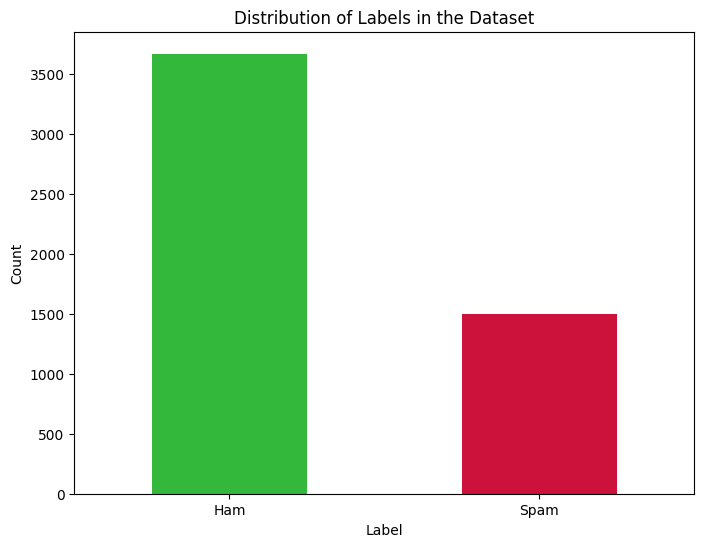

In [7]:
# Tính toán số lượng mỗi nhãn
label_counts = df['label'].value_counts()

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['#33B83B', '#CC123B'])
plt.title('Distribution of Labels in the Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'], rotation=0)
plt.show()

In [6]:
print("Train label distribution:\n", train_data['label'].value_counts())
print("Test label distribution:\n", test_data['label'].value_counts())

Train label distribution:
 label
0    2930
1    1206
Name: count, dtype: int64
Test label distribution:
 label
0    742
1    293
Name: count, dtype: int64


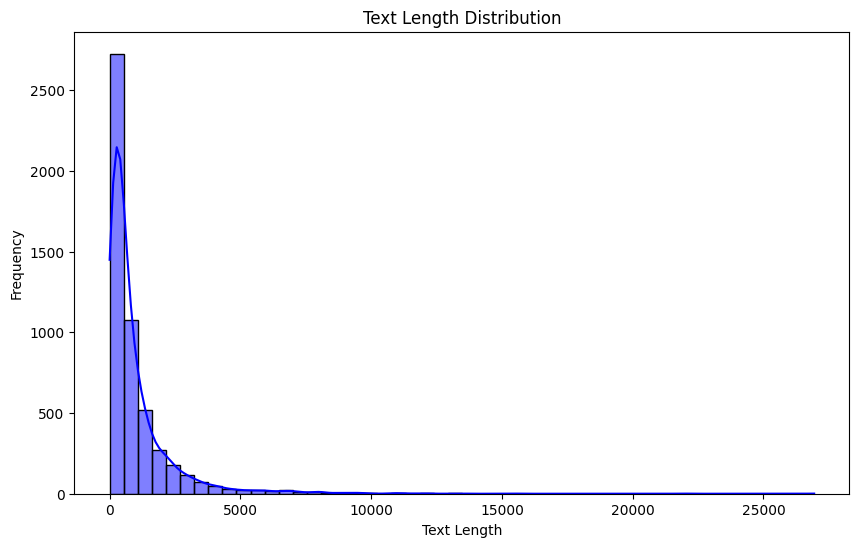

In [9]:
# Tính độ dài văn bản
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], kde=True, color='blue', bins=50)
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()


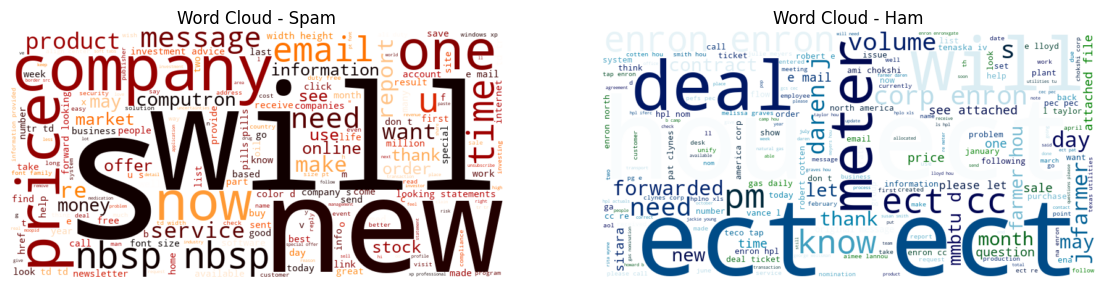

In [10]:
from wordcloud import WordCloud

# Tạo WordCloud cho spam và ham
spam_text = ' '.join(df[df['label'] == 1]['text'])
ham_text = ' '.join(df[df['label'] == 0]['text'])

plt.figure(figsize=(14, 7))

# WordCloud cho Spam
plt.subplot(1, 2, 1)
wordcloud_spam = WordCloud(width=800, height=400, background_color='white', colormap='gist_heat').generate(spam_text)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.title("Word Cloud - Spam")
plt.axis('off')

# WordCloud cho Ham
plt.subplot(1, 2, 2)
wordcloud_ham = WordCloud(width=800, height=400, background_color='white', colormap='ocean').generate(ham_text)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.title("Word Cloud - Ham")
plt.axis('off')

plt.show()


# Bert Model

## Dữ liệu cho model

In [4]:
# Dataset tùy chỉnh
class SpamDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['text']
        label = self.data.iloc[index]['label']
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [5]:
# Hàm chia dữ liệu và tạo DataLoader cho từng client
def load_datasets(train_data, test_data, client_id, tokenizer):
    """
    Chia dữ liệu huấn luyện và kiểm tra dựa trên client_id.
    
    Args:
        train_data (pd.DataFrame): Dữ liệu huấn luyện.
        test_data (pd.DataFrame): Dữ liệu kiểm tra.
        client_id (int): ID của client hiện tại.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer BERT.
        num_clients (int): Tổng số client.
    
    Returns:
        train_loader (DataLoader): DataLoader cho tập huấn luyện.
        test_loader (DataLoader): DataLoader cho tập kiểm tra.
    """
    if client_id >= NUM_CLIENTS or client_id < 0:
        raise ValueError(f"client_id phải nằm trong khoảng từ 0 đến {NUM_CLIENTS-1}")

    train_partition = np.array_split(train_data, NUM_CLIENTS)[client_id]
    test_partition = np.array_split(test_data, NUM_CLIENTS)[client_id]

    if len(train_partition) == 0 or len(test_partition) == 0:
        raise ValueError(f"Client {client_id} không có dữ liệu sau khi phân chia.")

    print(f"Client {client_id+1}: Train size = {len(train_partition)}, Test size = {len(test_partition)}")

    train_dataset = SpamDataset(train_partition, tokenizer)
    test_dataset = SpamDataset(test_partition, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    return train_loader, test_loader

# Tạo tokenizer BERT một lần duy nhất
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
# Kiểm tra dữ liệu cho từng client
for client_id in range(NUM_CLIENTS):    
    # Lấy DataLoader cho client hiện tại
    train_loader, test_loader = load_datasets(train_data, test_data, client_id, tokenizer)

print("Chia dữ liệu thành công!")


Client 1: Train size = 1034, Test size = 259
Client 2: Train size = 1034, Test size = 259
Client 3: Train size = 1034, Test size = 259
Client 4: Train size = 1034, Test size = 258
Chia dữ liệu thành công!


c:\Users\LENOVO\anaconda3\envs\spam_email_detect\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## Model

In [7]:
class BertNet(nn.Module):
    def __init__(self, model_name: str = 'bert-base-uncased', num_labels: int = 2, device: torch.device = None):
        super(BertNet, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Default to GPU if available

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits


In [8]:
def train(model, train_loader, optimizer, criterion, device, epochs=1):
    model.train()
    for epoch in range(epochs):
        correct, total = 0, 0
        epoch_loss = 0.0

        with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{epochs}") as tepoch:
            for batch in tepoch:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                optimizer.zero_grad()

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                total += labels.size(0)
                correct += (outputs.argmax(dim=1) == labels).sum().item()

                # Update progress bar
                tepoch.set_postfix(loss=epoch_loss / total, accuracy=correct / total)

        avg_loss = epoch_loss / len(train_loader)
        accuracy = correct / total
        print(f"Epoch {epoch+1}: Train loss {avg_loss:.4f}, Accuracy {accuracy:.4f}")

In [9]:
# Hàm kiểm tra
def test(model, test_loader, criterion, device):
    model.eval()
    correct, total, loss = 0, 0, 0.0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss += criterion(outputs, labels).item()
            total += labels.size(0)
            correct += (outputs.argmax(dim=1) == labels).sum().item()

    loss /= len(test_loader)
    accuracy = correct / total
    return loss, accuracy

In [10]:
# Huấn luyện mô hình
# Khởi tạo mô hình, optimizer và criterion
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = BertNet('bert-base-uncased', device=device).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Lấy DataLoader cho client 0 (ví dụ)
train_loader, test_loader = load_datasets(train_data, test_data, client_id=0, tokenizer=tokenizer)

Client 1: Train size = 1034, Test size = 259


In [12]:
# Huấn luyện mô hình
for epoch in range(1):
    print(f"Epoch {epoch+1} started")
    train(net, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch+1} completed\n")

# Kiểm tra trên tập test
test_loss, test_accuracy = test(net, test_loader, criterion, device)
print(f"Final test set performance:\n\tLoss: {test_loss}\n\tAccuracy: {test_accuracy}")

Epoch 1 started


Epoch 1/1: 100%|██████████| 130/130 [07:36<00:00,  3.51s/batch, accuracy=0.895, loss=0.0306]


Epoch 1: Train loss 0.2437, Accuracy 0.8946
Epoch 1 completed

Final test set performance:
	Loss: 0.08029774167208058
	Accuracy: 0.9768339768339769


In [13]:
# Lưu mô hình sau khi huấn luyện
model_path = "bert_model.pth"

In [14]:
# Chỉ lưu tham số mô hình
torch.save(net.state_dict(), model_path)
print(f"Mô hình đã được lưu tại: {model_path}")

Mô hình đã được lưu tại: bert_model.pth


## Đánh giá mô hình

# Federated with Flower

In [15]:
# Khởi tạo mô hình với cấu trúc giống như lúc huấn luyện
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = BertNet('bert-base-uncased', device=device).to(device)


# Tải các tham số đã lưu vào mô hình
model_path = "bert_model.pth"
net.load_state_dict(torch.load(model_path, map_location=device))  # Chỉ định map_location cho device

net.eval()  # Chuyển mô hình về chế độ đánh giá (eval mode)

print("Mô hình đã được tải và sẵn sàng sử dụng.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_84\3716702122.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializat

Mô hình đã được tải và sẵn sàng sử dụng.


In [16]:
# Hàm cập nhật tham số mô hình
def set_parameters(net, parameters: List[np.ndarray]):
    """
    Cập nhật tham số mô hình từ danh sách numpy array.
    """
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v).to(net.device) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

# Hàm lấy tham số mô hình
def get_parameters(net) -> List[np.ndarray]:
    """
    Trích xuất tham số mô hình dưới dạng danh sách numpy array.
    """
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [17]:
# Định nghĩa FlowerClient
class FlowerClient(NumPyClient):
    def __init__(self, net, train_loader, test_loader, device):
        self.net = net.to(device)  # Đưa mô hình vào thiết bị
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device

        # Cấu hình optimizer và loss function
        self.optimizer = torch.optim.AdamW(self.net.parameters(), lr=1e-5)
        self.criterion = torch.nn.CrossEntropyLoss()

    def get_parameters(self, config):
        """Lấy tham số mô hình."""
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.train_loader, self.optimizer, self.criterion, self.device, epochs=1)
        return get_parameters(self.net), len(self.train_loader), {}

    def fit(self, parameters, config):
        print(f"Client đang huấn luyện...")
        set_parameters(self.net, parameters)

        train(self.net, self.train_loader, self.optimizer, self.criterion, self.device, epochs=1)

        print(f"Client huấn luyện xong. Trả về tham số.")
        return get_parameters(self.net), len(self.train_loader), {}

    def evaluate(self, parameters, config):
        print(f"Client đang đánh giá...")
        set_parameters(self.net, parameters)

        loss, accuracy = test(self.net, self.test_loader, self.criterion, self.device)

        print(f"Client đánh giá xong. Loss: {loss}, Accuracy: {accuracy}")
        return float(loss), len(self.test_loader), {"accuracy": float(accuracy)}


In [18]:
# Hàm tạo client cho Flower
def client_fn(context: Context) -> Client:
    """
    Tạo một Flower Client với dữ liệu riêng biệt dựa trên client_id.
    """
    client_id = context.node_config.get("partition-id", None)
    if client_id is None:
        raise ValueError("Không tìm thấy partition-id trong cấu hình client.")

    print(f"Khởi tạo client {client_id}...")

    # Tải dữ liệu
    train_loader, test_loader = load_datasets(
        train_data=train_data,
        test_data=test_data,
        client_id=client_id,
        tokenizer=tokenizer
    )

    # Khởi tạo mô hình và FlowerClient
    net = BertNet('bert-base-uncased', device=device).to(device)
    return FlowerClient(net, train_loader, test_loader, device).to_client()



In [19]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """
    Tính toán trung bình trọng số của các chỉ số accuracy trên nhiều client.
    
    Args:
        metrics (List[Tuple[int, Metrics]]): Danh sách các tuple, mỗi tuple chứa số lượng ví dụ và một dictionary chứa các chỉ số (ví dụ: accuracy).
    
    Returns:
        Metrics: Một dictionary với chỉ số accuracy tính theo trung bình trọng số.
    """
    # Tính toán trọng số (accuracy * số lượng ví dụ)
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Tính toán và trả về chỉ số trung bình trọng số
    return {"Accuracy": sum(accuracies) / sum(examples)}


In [20]:
# 7. Server Function
def server_fn(context: Context) -> ServerAppComponents:
    
    def log_round_start(round_number: int):
        print(f"=== Starting Round {round_number} ===")
        print(f"Client ID: {context.node_config.get('client_id')}")

    def log_round_end(round_number: int, results):
        print(f"Round {round_number} completed with results: {results}")

    
    strategy = FedAvg(
        fraction_fit=1.0,  # 100% clients tham gia huấn luyện
        fraction_evaluate=0.5, # 50% clients tham gia đánh giá
        min_fit_clients=4,  # Tối thiểu 5 clients tham gia huấn luyện
        min_evaluate_clients=2, # Tối thiểu 2 clients tham gia đánh giá
        min_available_clients=4,   # Tối thiểu 5 clients có sẵn
        evaluate_metrics_aggregation_fn=weighted_average # Hàm tính toán trung bình trọng số
    )
    
    # Gắn các hàm logging cho chiến lược
    strategy.on_round_begin = log_round_start
    strategy.on_round_end = log_round_end
    
    config = ServerConfig(num_rounds=1)
    return ServerAppComponents(strategy=strategy, config=config)


In [21]:
# Cấu hình tài nguyên
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}
if device.type == "cuda":
    backend_config["client_resources"]["num_gpus"] = 1.0

In [22]:
import os

# Disable oneDNN custom operations to avoid floating-point round-off errors
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Import TensorFlow and other required libraries
import tensorflow as tf

# Initialize TensorFlow
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


In [23]:
# 8. Chạy mô phỏng
server = ServerApp(server_fn=server_fn)
client = ClientApp(client_fn=client_fn)
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
    verbose_logging=True
)

DEBUG 2024-11-26 00:51:20,045:     Asyncio event loop already running.


DEBUG 2024-11-26 00:51:20,047:     Logger propagate set to False
DEBUG 2024-11-26 00:51:20,048:     Pre-registering run with id 4962201392176519952
DEBUG 2024-11-26 00:51:20,058:     Using InMemoryState
DEBUG 2024-11-26 00:51:20,065:     Using InMemoryState
INFO 2024-11-26 00:51:20,368:      Starting Flower ServerApp, config: num_rounds=1, no round_timeout
DEBUG 2024-11-26 00:51:20,372:     Buffer time delay: 5s
INFO 2024-11-26 00:51:20,372:      
INFO 2024-11-26 00:51:20,374:      [INIT]
INFO 2024-11-26 00:51:20,375:      Requesting initial parameters from one random client
DEBUG 2024-11-26 00:51:25,377:     Using InMemoryState
DEBUG 2024-11-26 00:51:25,378:     Registered 4 nodes
DEBUG 2024-11-26 00:51:25,379:     Supported backends: ['ray']
DEBUG 2024-11-26 00:51:25,381:     Initialising: RayBackend
DEBUG 2024-11-26 00:51:25,382:     Backend config: {'client_resources': {'num_cpus': 1, 'num_gpus': 0.0}, 'init_args': {}, 'actor': {'tensorflow': 0}}
2024-11-26 00:51:30,188	INFO worker

(ClientAppActor pid=38176) Khởi tạo client 3...
(ClientAppActor pid=38176) Client 4: Train size = 1034, Test size = 258


(ClientAppActor pid=38176) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=38176) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO 2024-11-26 00:52:22,980:      Received initial parameters from one random client
INFO 2024-11-26 00:52:23,008:      Starting evaluation of initial global parameters
INFO 2024-11-26 00:52:23,012:      Evaluation returned no results (`None`)
INFO 2024-11-26 00:52:23,014:      
INFO 2024-11-26 00:52:23,015:      [ROUND 1]
INFO 2024-11-26 00:52:23,019:      configure_fit: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=38176) c:\Users\LENOVO\anaconda3\envs\spam_email_detect\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.tr

(ClientAppActor pid=38176) Khởi tạo client 3...
(ClientAppActor pid=38176) Client 4: Train size = 1034, Test size = 258


(ClientAppActor pid=38176) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=38176) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(ClientAppActor pid=38176) Client đang huấn luyện...


Epoch 1/1:   0%|          | 0/130 [00:00<?, ?batch/s]
(ClientAppActor pid=20936) c:\Users\LENOVO\anaconda3\envs\spam_email_detect\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
(ClientAppActor pid=20936)   return bound(*args, **kwds)


(ClientAppActor pid=20936) Khởi tạo client 1...
(ClientAppActor pid=20936) Client 2: Train size = 1034, Test size = 259


(ClientAppActor pid=20936) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=20936) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(ClientAppActor pid=20936) Client đang huấn luyện...
(ClientAppActor pid=18768) Khởi tạo client 0...
(ClientAppActor pid=18768) Client 1: Train size = 1034, Test size = 259


(ClientAppActor pid=18768) c:\Users\LENOVO\anaconda3\envs\spam_email_detect\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
(ClientAppActor pid=18768)   return bound(*args, **kwds)
(ClientAppActor pid=18768) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=18768) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(ClientAppActor pid=18768) Client đang huấn luyện...


Epoch 1/1:   0%|          | 0/130 [00:00<?, ?batch/s]


(ClientAppActor pid=35684) Khởi tạo client 2...
(ClientAppActor pid=35684) 


(ClientAppActor pid=35684) c:\Users\LENOVO\anaconda3\envs\spam_email_detect\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
(ClientAppActor pid=35684)   return bound(*args, **kwds)


(ClientAppActor pid=35684) Client 3: Train size = 1034, Test size = 259


(ClientAppActor pid=35684) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=35684) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(ClientAppActor pid=35684) Client đang huấn luyện...


Epoch 1/1:  70%|███████   | 91/130 [58:02<17:45, 27.31s/batch, accuracy=0.821, loss=0.0481]
INFO 2024-11-26 01:52:24,469:      aggregate_fit: received 0 results and 4 failures
INFO 2024-11-26 01:52:24,477:      configure_evaluate: strategy sampled 2 clients (out of 4)
Epoch 1/1:  78%|███████▊  | 102/130 [1:01:57<35:30, 76.08s/batch, accuracy=0.87, loss=0.0419]
(ClientAppActor pid=17360) c:\Users\LENOVO\anaconda3\envs\spam_email_detect\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
(ClientAppActor pid=17360)   return bound(*args, **kwds)


(ClientAppActor pid=17360) Khởi tạo client 3...
(ClientAppActor pid=17360) Client 4: Train size = 1034, Test size = 258


(ClientAppActor pid=17360) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=17360) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(ClientAppActor pid=17360) Client đang đánh giá...
(ClientAppActor pid=23948) Khởi tạo client 2...
(ClientAppActor pid=23948) Client 3: Train size = 1034, Test size = 259
(ClientAppActor pid=23948) Client đang đánh giá...


(ClientAppActor pid=23948) c:\Users\LENOVO\anaconda3\envs\spam_email_detect\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
(ClientAppActor pid=23948)   return bound(*args, **kwds)
(ClientAppActor pid=23948) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=23948) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/1:  79%|███████▉  | 103/130 [1:04:53<47:48, 106.24s/batch, accuracy=0.87, loss=0.0418]


(ClientAppActor pid=23948) Client đánh giá xong. Loss: 0.6512128620436697, Accuracy: 0.6872586872586872


Epoch 1/1:  74%|███████▍  | 96/130 [1:05:07<44:32, 78.61s/batch, accuracy=0.826, loss=0.047] [repeated 2x across cluster]
INFO 2024-11-26 01:59:23,031:      aggregate_evaluate: received 2 results and 0 failures


(ClientAppActor pid=17360) Client đánh giá xong. Loss: 0.6443811239618243, Accuracy: 0.686046511627907


INFO 2024-11-26 01:59:23,047:      
INFO 2024-11-26 01:59:23,047:      [SUMMARY]
INFO 2024-11-26 01:59:23,047:      Run finished 1 round(s) in 4020.03s
INFO 2024-11-26 01:59:23,047:      	History (loss, distributed):
INFO 2024-11-26 01:59:23,047:      		round 1: 0.6477969930027471
INFO 2024-11-26 01:59:23,047:      	History (metrics, distributed, evaluate):
INFO 2024-11-26 01:59:23,047:      	{'Accuracy': [(1, 0.6866525994432972)]}
INFO 2024-11-26 01:59:23,047:      
DEBUG 2024-11-26 01:59:23,628:     ServerApp finished running.
DEBUG 2024-11-26 01:59:23,628:     ServerApp finished running.
DEBUG 2024-11-26 01:59:23,628:     Triggered stop event for Simulation Engine.
Epoch 1/1:  94%|█████████▍| 122/130 [1:21:31<05:10, 38.76s/batch, accuracy=0.859, loss=0.0425]


(ClientAppActor pid=38176) Epoch 1: Train loss 0.2914, Accuracy 0.8897
(ClientAppActor pid=38176) Client huấn luyện xong. Trả về tham số.


Epoch 1/1: 100%|██████████| 130/130 [1:24:04<00:00, 38.80s/batch, accuracy=0.861, loss=0.0415]


(ClientAppActor pid=20936) Epoch 1: Train loss 0.3302, Accuracy 0.8607
(ClientAppActor pid=20936) Client huấn luyện xong. Trả về tham số.
(ClientAppActor pid=18768) Epoch 1: Train loss 0.3185, Accuracy 0.8588
(ClientAppActor pid=18768) Client huấn luyện xong. Trả về tham số.


Epoch 1/1: 100%|██████████| 130/130 [1:28:45<00:00, 40.97s/batch, accuracy=0.882, loss=0.037] 


(ClientAppActor pid=35684) Epoch 1: Train loss 0.2947, Accuracy 0.8820
(ClientAppActor pid=35684) Client huấn luyện xong. Trả về tham số.


DEBUG 2024-11-26 02:23:22,208:     Terminated 12 actors
DEBUG 2024-11-26 02:23:24,228:     Terminated RayBackend
DEBUG 2024-11-26 02:23:24,302:     Stopping Simulation Engine now.


In [30]:
# Load the federated model
federated_model_path = "federated_bert_model.pth"
net.load_state_dict(torch.load(federated_model_path, map_location=device))
net.eval()

# Test the federated model on the test data
test_loss, test_accuracy = test(net, test_loader, criterion, device)
print(f"Federated model test set performance:\n\tLoss: {test_loss}\n\tAccuracy: {test_accuracy}")

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_84\3172498706.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(federated_model_path, map_locat

Federated model test set performance:
	Loss: 0.08029774167208058
	Accuracy: 0.9768339768339769


In [24]:
# Save the model after federated learning training
federated_model_path = "federated_bert_model.pth"
torch.save(net.state_dict(), federated_model_path)
print(f"Federated model has been saved at: {federated_model_path}")

Federated model has been saved at: federated_bert_model.pth
